In [1]:
import praw
import pandas as pd
import nltk
import time
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Reddit API credentials
reddit_client_id = 'j8TruYIbFf-tuIVd-UsUTg'
reddit_client_secret = 'tZz3i41QolvaZ1osGlsx1HRSWp22tg'
reddit_user_agent = 'FormalAdvertising896'

# Authenticate with Reddit
reddit = praw.Reddit(
    client_id=reddit_client_id,
    client_secret=reddit_client_secret,
    user_agent=reddit_user_agent
)

In [3]:
# Specify the subreddit and search query
subreddit_name = 'samsung'
search_query = 'Galaxy S'

In [4]:
# Get the subreddit instance
subreddit = reddit.subreddit(subreddit_name)

# Search for posts containing the specified query
posts = subreddit.search(search_query, sort='new', limit=25)

# Create a list to store post and comment details
post_comments_data = []

# Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Iterate through each post and extract comments
for post in posts:
    post.comments.replace_more(limit=None)  # Fetch all comments, including nested ones
    
    # Additional post details
    author = post.author.name if post.author else None
    
    # Retrieve Redditor object for the author
    author_redditor = reddit.redditor(author) if author else None
    
    # Additional post details from the Redditor object
    total_posts = len(list(author_redditor.submissions.new(limit=None))) if author_redditor else None
    total_comments = len(list(author_redditor.comments.new(limit=None))) if author_redditor else None
    link_karma = author_redditor.link_karma if author_redditor else None
    comment_karma = author_redditor.comment_karma if author_redditor else None
    score = post.score
    
    for comment in post.comments.list():
        sentiment_score = sia.polarity_scores(comment.body)['compound']

        sentiment = 'Positive' if sentiment_score >= 0.05 else 'Neutral' if -0.05 < sentiment_score < 0.05 else 'Negative'

        post_comments_data.append({
            'Post_Title': post.title,
            'Author': author,
            'Total_Posts': total_posts,
            'Total_Comments': total_comments,
            'Link_Karma': link_karma,
            'Comment_Karma': comment_karma,
            'Score': score,
            'Comment': comment.body,
            'Sentiment': sentiment,
            'Sentiment_Score': sentiment_score
        })
        
    # Introduce a delay between requests
    time.sleep(2)

In [5]:
# Create a DataFrame from the list
dfGalaxyS = pd.DataFrame(post_comments_data)

In [6]:
# Calculate an influence score based on upvotes, comments, and overall activity
dfGalaxyS['Influence_Score'] = dfGalaxyS['Score'] + dfGalaxyS['Total_Posts'] + dfGalaxyS['Total_Comments']

In [7]:
# Display the DataFrame
print(dfGalaxyS.head())

                Post_Title      Author  Total_Posts  Total_Comments  \
0  Reserve the Galaxy S24?  soparklion          386             998   
1  Reserve the Galaxy S24?  soparklion          386             998   
2  Reserve the Galaxy S24?  soparklion          386             998   
3  Reserve the Galaxy S24?  soparklion          386             998   
4  Reserve the Galaxy S24?  soparklion          386             998   

   Link_Karma  Comment_Karma  Score  \
0       13450          32119      1   
1       13450          32119      1   
2       13450          32119      1   
3       13450          32119      1   
4       13450          32119      1   

                                             Comment Sentiment  \
0  I'm not sure. But I have the s23 Ultra 512gb, ...  Positive   
1  you would need to trade a premium phone that w...   Neutral   
2  You would need to trade in Z fold 5 or Iphonr ...  Positive   
3  Ever since they started doing the fold collect...  Positive   
4       

In [8]:
# Identify top influencers
topInfluencers = dfGalaxyS.sort_values(by='Influence_Score', ascending=False).head(10)

# Display top influencers
print("Top Influencers:")
print(topInfluencers[['Author', 'Influence_Score']])

Top Influencers:
       Author  Influence_Score
38  just_mdd4             1855
37  just_mdd4             1855
36  just_mdd4             1855
35  just_mdd4             1855
34  just_mdd4             1855
56    kirsion             1775
55    kirsion             1775
57    kirsion             1775
58    kirsion             1775
59    kirsion             1775


In [9]:
# Identify top unique influencers
topUniqueInfluencers = dfGalaxyS.drop_duplicates(subset='Author').sort_values(by='Influence_Score', ascending=False).head(10)

# Display top unique influencers
print("Top Unique Influencers:")
print(topUniqueInfluencers[['Author', 'Influence_Score']])

Top Unique Influencers:
                Author  Influence_Score
34           just_mdd4             1855
55             kirsion             1775
0           soparklion             1385
6          leapingfro9             1297
39           Maj-Thicc             1049
339        NomusaMagic             1040
279     ManInBlack6942              781
335   Mr_Swag_Official              761
311  United_Falcon7287              667
65     YouCanBetOnItMs              592


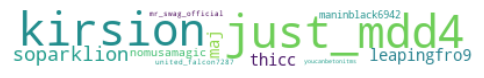

In [10]:
# Concatenate all authors into a single string based on their influence score
all_author_text = ' '.join(dfGalaxyS.drop_duplicates(subset='Author').sort_values(by='Influence_Score', ascending=False).head(10)['Author'].apply(lambda x: str(x).lower() if pd.notna(x) else '').tolist())

# Generate word cloud
wordcloudAuthor = WordCloud(width=400, height=50, background_color='white').generate(all_author_text)

# Display the generated word cloud
plt.figure(figsize=(6, 3))
plt.imshow(wordcloudAuthor, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter

In [12]:
# Function to extract keywords and their frequencies from a text
def extract_keywords(text):
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in word_tokenize(text) if word.isalnum() and word.lower() not in stop_words]
    return FreqDist(words)

In [13]:
# Apply the function to the 'Comment' column to get keywords and frequencies
dfGalaxyS['Keywords'] = dfGalaxyS['Comment'].apply(extract_keywords)

# Group sentiments and keywords by hashtag
groupedData = dfGalaxyS.groupby(['Sentiment']).agg({'Keywords': 'sum'}).reset_index()

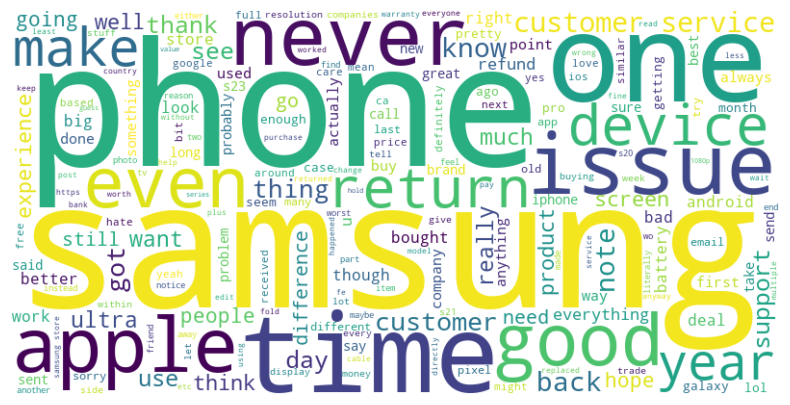

Top Keywords:
[('samsung', 100), ('phone', 63), ('get', 45), ('like', 45), ('would', 43), ('customer', 42), ('one', 35), ('never', 33), ('service', 32), ('apple', 30)]


In [14]:
# Concatenate all comments' keywords into a single string
allKeywordsText = ' '.join(dfGalaxyS['Keywords'].explode().apply(lambda x: str(x).lower() if pd.notna(x) else '').tolist())

# Generate word cloud
wordcloudKeywords = WordCloud(width=800, height=400, background_color='white').generate(allKeywordsText)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloudKeywords, interpolation='bilinear')
plt.axis('off')
plt.show()

# Identify top keywords
topKeywordsCount = Counter(allKeywordsText.split())
topKeywords = topKeywordsCount.most_common(10)

# Display top keywords
print("Top Keywords:")
print(topKeywords)

In [15]:
# Extract hashtags
hashtags = [word for word in dfGalaxyS['Comment'].str.split().explode() if word.startswith('#')]

# Calculate frequency distribution for hashtags
hashtag_freq = FreqDist(hashtags)

# Display hashtags
print("\nHashtags:")
for hashtag, freq in hashtag_freq.most_common(5):
    print(f"{hashtag}: {freq} times")


Hashtags:
#1: 1 times
#2: 1 times


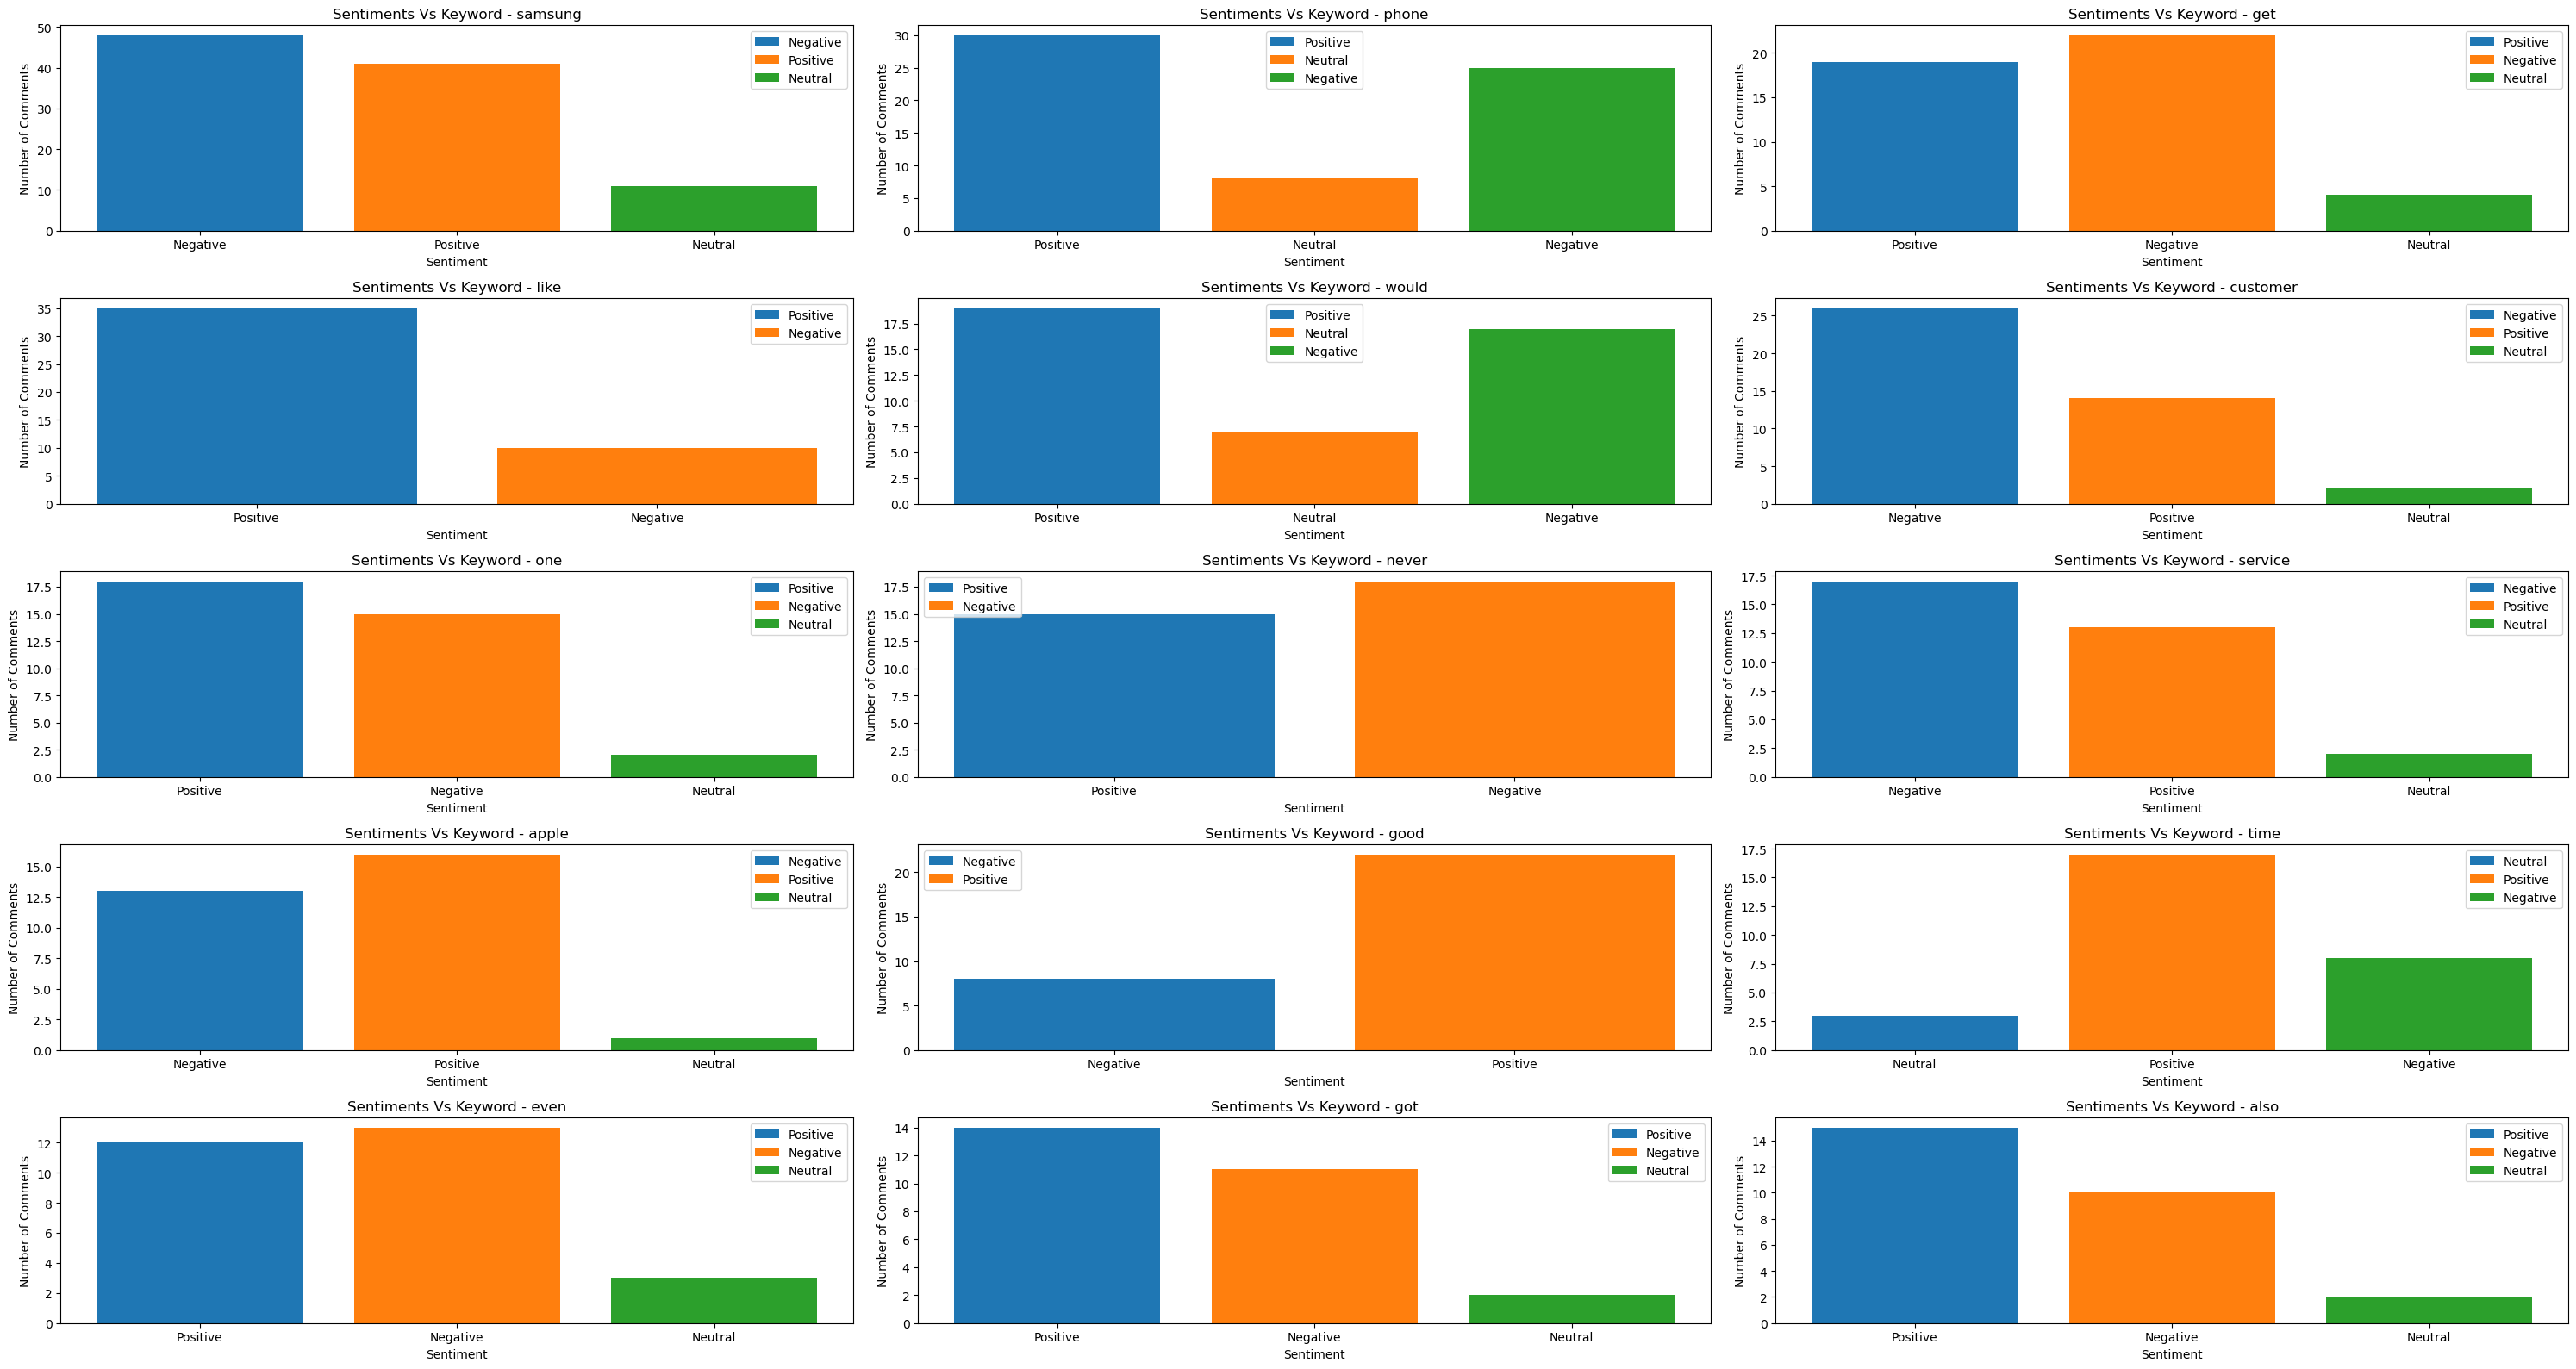

In [16]:
# Identify the top 10 keywords based on occurrences
topKeywords = dfGalaxyS['Keywords'].explode().value_counts().nlargest(15).index

# Visualize sentiments vs keywords for the top 10 keywords
num_cols = 3  # Number of columns in the subplot grid
num_rows = -(-len(topKeywords) // num_cols)  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 16))  # Adjust the figure size as needed

for i, keyword in enumerate(topKeywords):
    row, col = divmod(i, num_cols)
    subset = dfGalaxyS[dfGalaxyS['Keywords'].apply(lambda x: keyword in x)]
    ax = axs[row, col] if num_rows > 1 else axs[col]

    for sentiment in subset['Sentiment'].unique():
        sentiment_subset = subset[subset['Sentiment'] == sentiment]
        ax.bar(sentiment_subset['Sentiment'], sentiment_subset.shape[0], label=sentiment)

    ax.set_title(f'Sentiments Vs Keyword - {keyword}')
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Number of Comments')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [17]:
# Extract unique authors and their keywords with frequency
author_keywords_data = []

for author in dfGalaxyS['Author'].unique():
    author_subset = dfGalaxyS[dfGalaxyS['Author'] == author]
    
    # Concatenate all keywords into a single string
    all_keywords_text = ' '.join(author_subset['Keywords'].explode().apply(lambda x: str(x).lower() if pd.notna(x) else '').tolist())
    
    # Calculate keyword frequencies
    keyword_freq = Counter(all_keywords_text.split())
    
    # Sort keywords by frequency in descending order
    sorted_keywords = sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True)
    
    author_keywords_data.append({
        'Author': author,
        'Influence_Score': author_subset['Influence_Score'].iloc[0],  # Taking the first value, assuming it's the same for all rows of the same author
        'Keywords': sorted_keywords
    })

# Create a new DataFrame from the list
dfAuthorKeywords = pd.DataFrame(author_keywords_data)

# Display the new DataFrame
print(dfAuthorKeywords.head(10))

               Author  Influence_Score  \
0          soparklion             1385   
1  cardsdowngunsdrawn              322   
2         leapingfro9             1297   
3           just_mdd4             1855   
4           Maj-Thicc             1049   
5    Kevin_Eats_Sushi              139   
6             kirsion             1775   
7           JObersi10              339   
8     YouCanBetOnItMs              592   
9        MasterN00b22               39   

                                            Keywords  
0  [(would, 3), (trade, 3), (max, 3), (get, 2), (...  
1  [(work, 1), (apps, 1), (profile, 1), (want, 1)...  
2  [(difference, 11), (fhd, 8), (notice, 8), (pho...  
3  [(tab, 2), (confusing, 1), (many, 1), (ppl, 1)...  
4  [(yea, 1), (pc, 1), (laptops, 1), (tend, 1), (...  
5  [(note, 7), (ultra, 6), (fe, 5), (series, 4), ...  
6  [(know, 2), (june, 2), (lowest, 2), (price, 2)...  
7  [(big, 4), (battery, 3), (difference, 3), (thi...  
8  [(sleep, 1), (pretty, 1), (cool, 1), (a

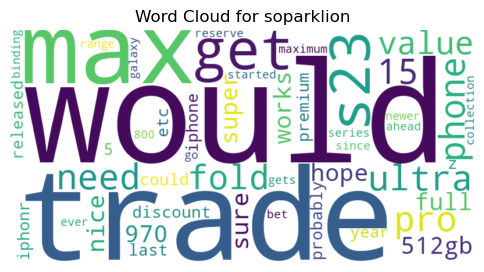

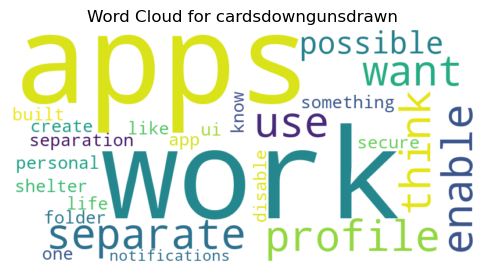

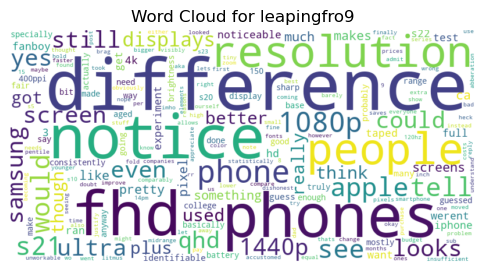

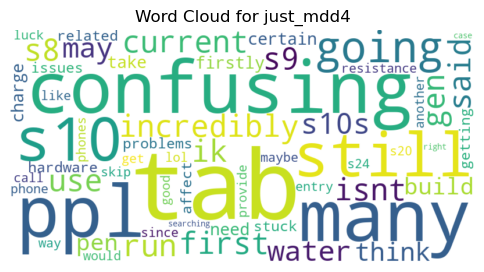

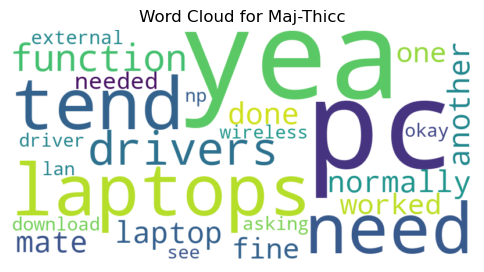

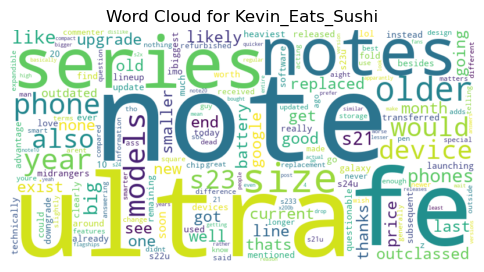

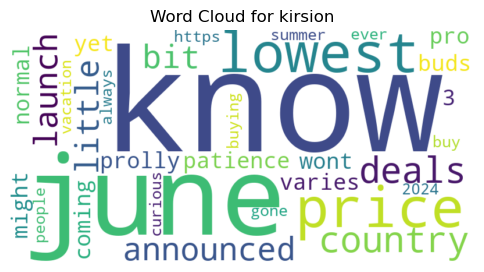

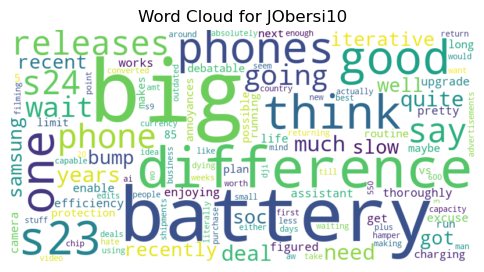

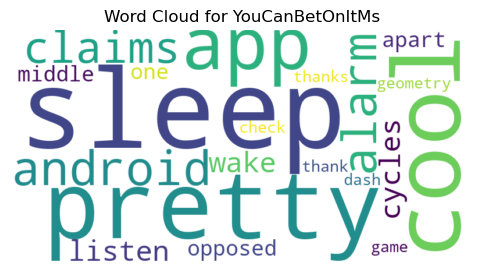

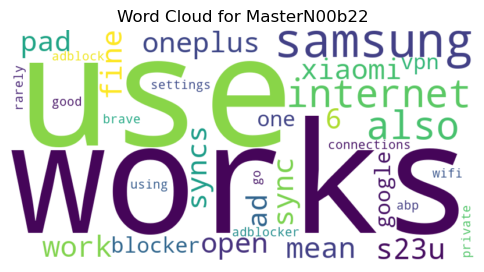

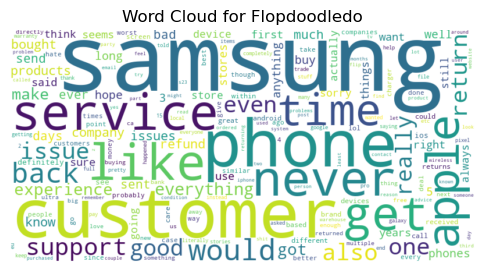

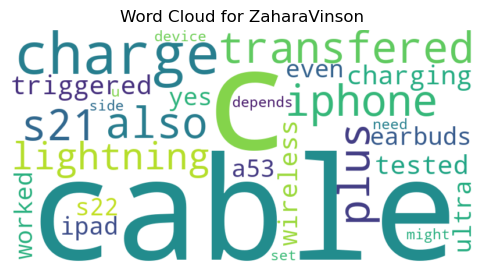

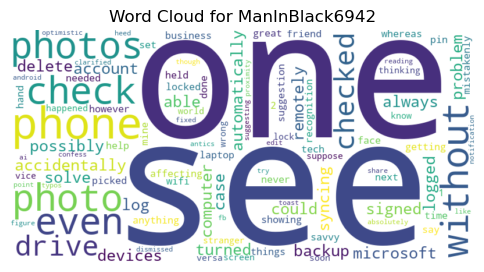

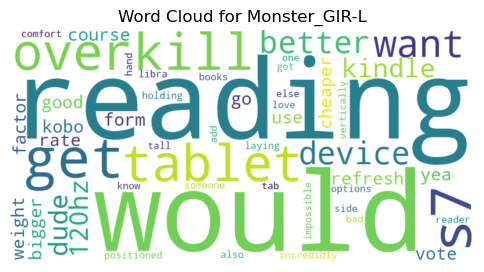

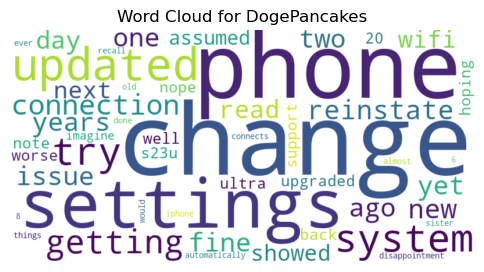

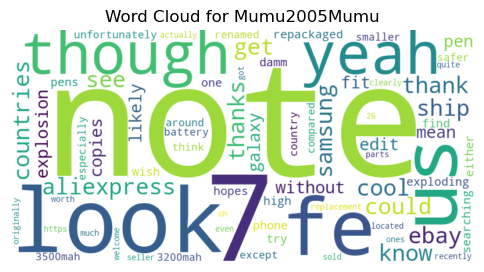

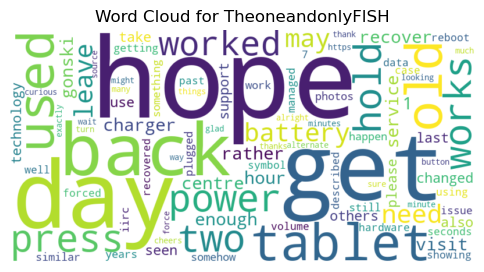

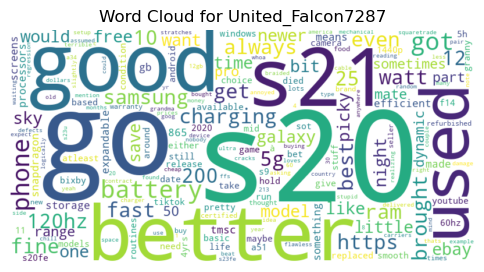

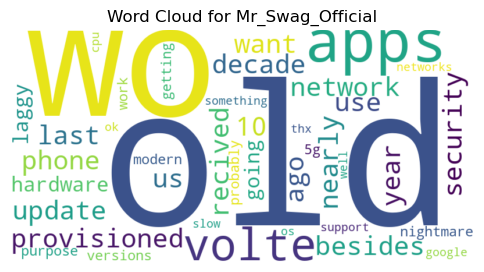

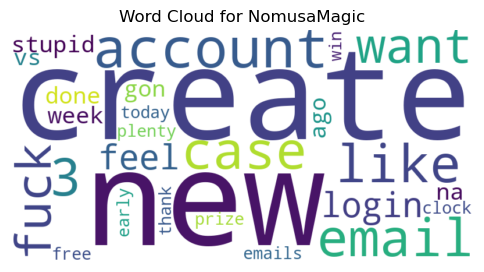

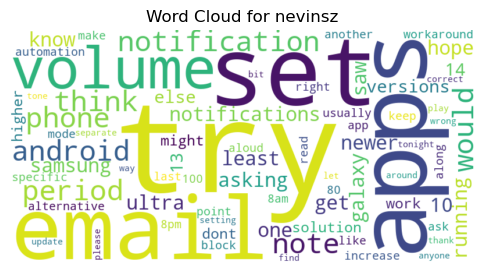

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract unique authors and their keywords with frequency
for author in dfAuthorKeywords['Author'].unique():
    author_data = dfAuthorKeywords[dfAuthorKeywords['Author'] == author].iloc[0]
    keywords_dict = dict(author_data['Keywords'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_dict)

    # Display the generated word cloud
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {author}')
    plt.axis('off')
    plt.show()

In [19]:
# Create a new DataFrame for sentiment analysis
dfSentiment = pd.DataFrame(columns=['Author', 'Post_Score', 'Influence_Score', 'Positive_Score', 'Neutral_Score', 'Negative_Score'])

# Extract unique authors and their sentiment scores
for author in dfGalaxyS['Author'].unique():
    author_subset = dfGalaxyS[dfGalaxyS['Author'] == author]
    
    # Calculate sentiment scores
    positive_score = author_subset[author_subset['Sentiment'] == 'Positive']['Sentiment_Score'].mean()
    neutral_score = author_subset[author_subset['Sentiment'] == 'Neutral']['Sentiment_Score'].mean()
    negative_score = author_subset[author_subset['Sentiment'] == 'Negative']['Sentiment_Score'].mean()
    
    # Append data to the new DataFrame
    dfSentiment = dfSentiment.append({
        'Author': author,
        'Post_Score': author_subset['Score'].iloc[0],  # Assuming post score is the same for all posts by the author
        'Influence_Score': author_subset['Influence_Score'].iloc[0],  # Assuming influence score is the same for all posts by the author
        'Positive_Score': positive_score if not pd.isna(positive_score) else 0,
        'Neutral_Score': neutral_score if not pd.isna(neutral_score) else 0,
        'Negative_Score': negative_score if not pd.isna(negative_score) else 0,
    }, ignore_index=True)

# Display the new DataFrame
print(dfSentiment.head(10))

               Author Post_Score Influence_Score  Positive_Score  \
0          soparklion          1            1385        0.526533   
1  cardsdowngunsdrawn          2             322        0.872000   
2         leapingfro9          0            1297        0.495020   
3           just_mdd4          2            1855        0.691550   
4           Maj-Thicc          1            1049        0.356450   
5    Kevin_Eats_Sushi          0             139        0.422571   
6             kirsion          0            1775        0.000000   
7           JObersi10          1             339        0.711033   
8     YouCanBetOnItMs          3             592        0.769750   
9        MasterN00b22          1              39        0.485400   

   Neutral_Score Negative_Score  
0            0.0              0  
1            0.0              0  
2            0.0       -0.41528  
3            0.0        -0.3381  
4            0.0              0  
5            0.0       -0.32885  
6            

C:\Users\athorat\AppData\Local\Temp\ipykernel_81444\1062017997.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfSentiment = dfSentiment.append({
C:\Users\athorat\AppData\Local\Temp\ipykernel_81444\1062017997.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfSentiment = dfSentiment.append({
C:\Users\athorat\AppData\Local\Temp\ipykernel_81444\1062017997.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfSentiment = dfSentiment.append({
C:\Users\athorat\AppData\Local\Temp\ipykernel_81444\1062017997.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfSentiment = dfSentiment.append({
C:\Users\athorat\AppData\Local\Temp\ipyk

In [25]:
# Merge dfAuthorKeywords and dfSentiment DataFrames
dfMerged = pd.merge(dfAuthorKeywords, dfSentiment, on='Author', how='inner')

# Remove duplicate columns (e.g., 'Influence_Score' and 'Post_Score' are the same)
dfMerged = dfMerged.loc[:, ~dfMerged.columns.duplicated()]

# Display the merged DataFrame
print(dfMerged.head(10))

               Author  Influence_Score_x  \
0          soparklion               1385   
1  cardsdowngunsdrawn                322   
2         leapingfro9               1297   
3           just_mdd4               1855   
4           Maj-Thicc               1049   
5    Kevin_Eats_Sushi                139   
6             kirsion               1775   
7           JObersi10                339   
8     YouCanBetOnItMs                592   
9        MasterN00b22                 39   

                                            Keywords Post_Score  \
0  [(would, 3), (trade, 3), (max, 3), (get, 2), (...          1   
1  [(work, 1), (apps, 1), (profile, 1), (want, 1)...          2   
2  [(difference, 11), (fhd, 8), (notice, 8), (pho...          0   
3  [(tab, 2), (confusing, 1), (many, 1), (ppl, 1)...          2   
4  [(yea, 1), (pc, 1), (laptops, 1), (tend, 1), (...          1   
5  [(note, 7), (ultra, 6), (fe, 5), (series, 4), ...          0   
6  [(know, 2), (june, 2), (lowest, 2), (price,

In [21]:
import os
os.chdir('C:/Users/athorat/OneDrive - Nice Systems Ltd/00_Amit Thorat Data/ISB - AMPBA/01_Project/Term6_DSMA')

In [22]:
# Save the merged DataFrame to an Excel file
dfMerged.to_csv('aurthor_data.csv', index=False)

In [23]:
# Save the GalaxyS DataFrame to an Excel file
dfGalaxyS.to_csv('galaxyS_data.csv', index=False)